In [1]:
import numpy as np
import pandas as pd

def generate_staggered_law_ma1_data(N, T, theta, num_individuals, mean=0, std_dev=1):
    # Generate random white noise for each individual
    white_noise = np.random.normal(mean, std_dev, size=(N, num_individuals, T))

    # Initialize the array to store the data
    data = np.zeros((N, num_individuals, T))

    alphas = np.random.normal(0,1, size=N)
    betas = np.random.normal(0,1, size = T)

    # Generate the MA(1) process data for each individual
    for i in range(N):
        alpha = alphas[i]
        for j in range(num_individuals):
            for t in range(T):
                beta = betas[t]
                if t == 0:
                    data[i, j, t] = alpha + beta + white_noise[i, j, t]
                else:
                    data[i, j, t] = alpha + beta + white_noise[i, j, t] + theta * white_noise[i, j, t - 1]

    # The rest of the code remains the same for reshaping data and creating DataFrame

    reshaped_data = data.reshape((N * num_individuals, T))
    df = pd.DataFrame(reshaped_data, columns=[f'{t}' for t in range(T)])
    df['state'] = np.repeat(np.arange(1, N + 1), num_individuals)
    df['individual'] = np.tile(np.arange(1, num_individuals + 1), N)

    melted_df = pd.melt(df, id_vars=['state', 'individual'], var_name='time', value_name='value')
    melted_df['time'] = melted_df['time'].astype(int)
    data = melted_df.copy()
    data['time'] = data['time'].astype(int)

    state_dummies = pd.get_dummies(data['state'], prefix='state', drop_first = True)

    # Convert state dummy variables to int
    state_dummies = state_dummies.astype(int)

    # Create time dummy variables
    time_dummies = pd.get_dummies(data['time'].astype(int), prefix='time', drop_first = True)

    # Convert time dummy variables to int
    time_dummies = time_dummies.astype(int)

    data = pd.concat([data, state_dummies, time_dummies], axis=1)

    states = data['state'].unique()
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)
    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

    return data

c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


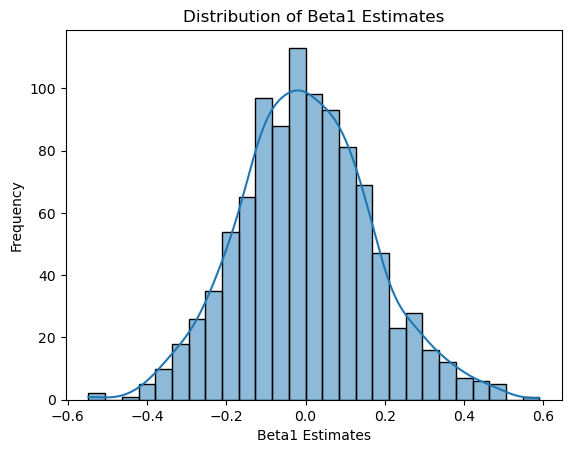

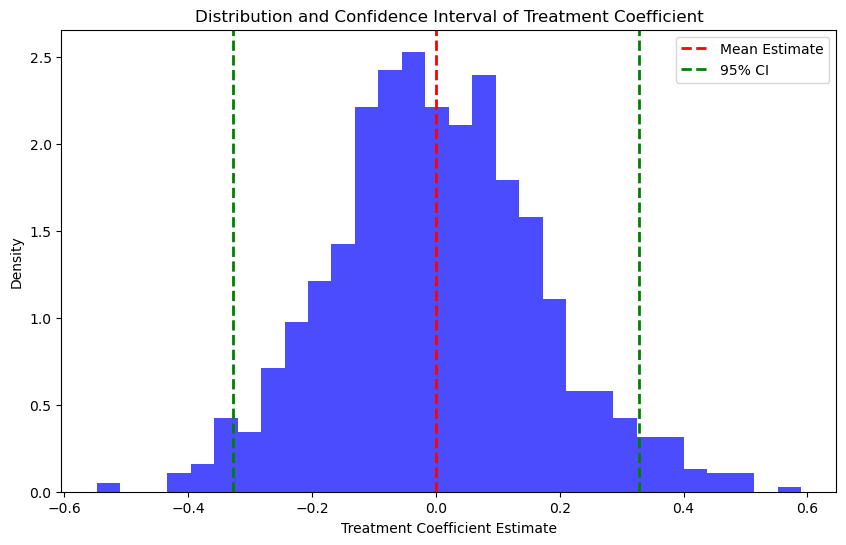

Number of times null hypothesis is rejected for : 57 out of 1000 simulations
Type 1 Error: 0.057
Bias for Coefficient of Treatment (True Value = 0): 0.000163214001949747
MSE for Coefficient of Treatment (True Value = 0): 0.0011844869314504387
Average RMSE for Coefficient of Treatment (True Value = 0): 0.034416375919762945
The confidence interval is (-0.3280546236713232, {0.3283810516752227})


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


beta1_estimates = []

reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
num_simulations = 1000
bias_values = []
squared_error_values = []
N = 50
T = 20
num_individuals = 1
theta = 0.5
true_beta1_value = 0
standard_error_values = []

bias_values = []

for _ in range(num_simulations):
    data = generate_staggered_law_ma1_data( N, T, theta, num_individuals)

    # Step 3: Perform the OLS regression
    X = data[['TREATMENT', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24', 'state_25', 'state_26', 'state_27', 'state_28', 'state_29',
       'state_30', 'state_31', 'state_32', 'state_33', 'state_34', 'state_35',
       'state_36', 'state_37', 'state_38', 'state_39', 'state_40', 'state_41',
       'state_42', 'state_43', 'state_44', 'state_45', 'state_46', 'state_47',
       'state_48', 'state_49', 'state_50', 'time_1', 'time_2', 'time_3',
       'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9', 'time_10',
       'time_11', 'time_12', 'time_13', 'time_14', 'time_15', 'time_16',
       'time_17', 'time_18', 'time_19']] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['value'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['state'].astype(str)})

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()

# Calculate the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)
plt.figure(figsize=(10, 6))
plt.hist(beta1_estimates, bins=30, density=True, color='blue', alpha=0.7)
plt.axvline(np.mean(beta1_estimates), color='red', linestyle='dashed', linewidth=2, label='Mean Estimate')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Treatment Coefficient Estimate')
plt.ylabel('Density')
plt.title('Distribution and Confidence Interval of Treatment Coefficient')
plt.legend()
plt.show()


# Print the number of rejections
# Print the number of rejections
print(f"Number of times null hypothesis is rejected for : {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")
print(f"Average RMSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_rmse}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')


